In [2]:
import pandas as pd
import polars as pl
import json
import os
from tqdm import tqdm
import shutil
from matplotlib import pyplot as plt

In [3]:
pred_df = pl.scan_csv('../outputs/labeling_round2/tmp_csv/ensemble_r101_x3d_convnexttiny2d_part0.csv').collect()
pred_df

shape: (806, 5)
┌─────────────┬──────────┬─────────┬───────────┬───────────┐
│ tomo_id     ┆ motor_z  ┆ motor_y ┆ motor_x   ┆ conf      │
│ ---         ┆ ---      ┆ ---     ┆ ---       ┆ ---       │
│ str         ┆ f64      ┆ f64     ┆ f64       ┆ f64       │
╞═════════════╪══════════╪═════════╪═══════════╪═══════════╡
│ tomo_033ebe ┆ 89.875   ┆ 710.5   ┆ 304.75    ┆ 0.679199  │
│ tomo_01a877 ┆ 143.625  ┆ 632.0   ┆ 285.25    ┆ 0.644043  │
│ tomo_0308c5 ┆ -1.0     ┆ -1.0    ┆ -1.0      ┆ 0.0       │
│ tomo_02862f ┆ 104.125  ┆ 350.25  ┆ 120.5     ┆ 0.65332   │
│ tomo_00e047 ┆ 169.75   ┆ 543.0   ┆ 604.5     ┆ 0.659668  │
│ …           ┆ …        ┆ …       ┆ …         ┆ …         │
│ tomo_fe85f6 ┆ 471.0    ┆ 896.0   ┆ 735.0     ┆ 0.401855  │
│ tomo_fe85f6 ┆ 441.75   ┆ 500.25  ┆ 11.710938 ┆ 0.261963  │
│ tomo_fea6e8 ┆ -1.0     ┆ -1.0    ┆ -1.0      ┆ 0.0       │
│ tomo_ff505c ┆ 108.1875 ┆ 814.0   ┆ 674.5     ┆ 0.702637  │
│ tomo_ff7c20 ┆ 309.75   ┆ 495.5   ┆ 65.4375   ┆ 0.6171875 │
└─────────────┴──────────┴─────────┴───────────┴───────────┘

In [12]:
pred_df.group_by('tomo_id').len('num_motors').group_by('num_motors').len().sort('num_motors')

shape: (8, 2)
┌────────────┬─────┐
│ num_motors ┆ len │
│ ---        ┆ --- │
│ u32        ┆ u32 │
╞════════════╪═════╡
│ 1          ┆ 560 │
│ 2          ┆ 55  │
│ 3          ┆ 16  │
│ 4          ┆ 8   │
│ 5          ┆ 2   │
│ 6          ┆ 4   │
│ 7          ┆ 2   │
│ 8          ┆ 1   │
└────────────┴─────┘

In [13]:
gt_df = pl.scan_csv('/home/dangnh36/datasets/.comp/byu/processed/gt_v2.csv').with_columns(
    pl.col('motor_zyx').map_elements(eval, return_dtype = pl.Object)
).collect()
# .select('tomo_id', 'motor_z', 'motor_y', 'motor_x', 'voxel_spacing', 'target_shape').collect()
gt_df

shape: (648, 20)
┌─────────────┬─────┬──────┬──────┬───┬──────────┬──────────┬───────────────────┬──────────────────┐
│ tomo_id     ┆ Z   ┆ Y    ┆ X    ┆ … ┆ motor_yA ┆ motor_xA ┆ motor_zyx         ┆ motor_zyxA       │
│ ---         ┆ --- ┆ ---  ┆ ---  ┆   ┆ ---      ┆ ---      ┆ ---               ┆ ---              │
│ str         ┆ i64 ┆ i64  ┆ i64  ┆   ┆ f64      ┆ f64      ┆ object            ┆ str              │
╞═════════════╪═════╪══════╪══════╪═══╪══════════╪══════════╪═══════════════════╪══════════════════╡
│ tomo_003acc ┆ 500 ┆ 1912 ┆ 1847 ┆ … ┆ -6.5     ┆ -6.5     ┆ []                ┆ []               │
│ tomo_00e047 ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 8517.6   ┆ 9406.8   ┆ [[169.0, 546.0,   ┆ [[2636.4,        │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 603.0]]           ┆ 8517.6, 9406.8]] │
│ tomo_00e463 ┆ 500 ┆ 924  ┆ 956  ┆ … ┆ 7939.1   ┆ 2698.9   ┆ [[235.0, 403.0,   ┆ [[4629.5, 7939.0 │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 137.0], [243.0…   ┆ 99999999999, 2…  │
│ tomo_01a877 ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ 8357.8   ┆ 3746.6   ┆ [[147.0, 638.0,   ┆ [[1925.7,        │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 286.0]]           ┆ 8357.8, 3746.6]] │
│ tomo_02862f ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 5475.6   ┆ 1872.0   ┆ [[101.0, 351.0,   ┆ [[1575.6, 5475.5 │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 120.0]]           ┆ 99999999999, 1…  │
│ …           ┆ …   ┆ …    ┆ …    ┆ … ┆ …        ┆ …        ┆ …                 ┆ …                │
│ tomo_fe050c ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 2090.4   ┆ 8455.2   ┆ [[138.0, 134.0,   ┆ [[2152.799999999 │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 542.0], [143.1…   ┆ 9997, 2090.4, …  │
│ tomo_fe85f6 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 11835.85 ┆ 9785.7   ┆ [[463.5, 903.5,   ┆ [[6071.849999999 │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 747.0]]           ┆ 999, 11835.85,…  │
│ tomo_fea6e8 ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ -16.8    ┆ -16.8    ┆ []                ┆ []               │
│ tomo_ff505c ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 12729.6  ┆ 10576.8  ┆ [[111.0, 816.0,   ┆ [[1731.6,        │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 678.0]]           ┆ 12729.6,         │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆                   ┆ 10576.8]]        │
│ tomo_ff7c20 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 6458.3   ┆ 825.3    ┆ [[307.25, 493.0,  ┆ [[4024.975,      │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 63.0]]            ┆ 6458.3, 825.3]]  │
└─────────────┴─────┴──────┴──────┴───┴──────────┴──────────┴───────────────────┴──────────────────┘

In [14]:
gt_df.group_by('num_motors').len().sort('num_motors')

shape: (7, 2)
┌────────────┬─────┐
│ num_motors ┆ len │
│ ---        ┆ --- │
│ i64        ┆ u32 │
╞════════════╪═════╡
│ 0          ┆ 231 │
│ 1          ┆ 359 │
│ 2          ┆ 35  │
│ 3          ┆ 10  │
│ 4          ┆ 9   │
│ 6          ┆ 3   │
│ 10         ┆ 1   │
└────────────┴─────┘

In [15]:
ALL_TOMO_IDS = sorted(list(gt_df['tomo_id'].unique()))
len(ALL_TOMO_IDS)

648

In [8]:
# ALL_TOMO_IDS = gt_df.group_by('tomo_id', maintain_order = True).len().group_by('len', maintain_order = True).first().sort('len')['tomo_id'].to_list()

In [16]:
EPSILON = 1e-5
import numpy as np
import scipy
from scipy.spatial.distance import cdist

def linear_assignment_hungarian(
        cost_matrix: np.ndarray,
        max_cost: float):
    """Linear assignment using Scipy's Hugarian method implementation.

    Linear assignment with specified max cost. All posible pair with higher cost
    will be treated equally (i.e having same cost in matching stage)
    and will not be treated as matched (gated).
    See https://github.com/nwojke/deep_sort/issues/84 or
    https://github.com/nwojke/deep_sort/issues/135 for more implementation details.

    Args:
        cost_matrix:
            Cost matrix of size M*N
        max_cost:
            Maximum cost allowed. A pair (cell) with higher cost will be gated.
    
    Returns:
        Tuple contain 3 list (matched, unmatched_a, unmatched_b).
        Each element in matched is in form of [a_idx, b_idx]
        unmatched_a contains row indices which are not matched.
        unmatched_b contains column indices which are not matched.
    """
    # treated every over range costs equally to remove bias
    # https://github.com/nwojke/deep_sort/issues/84
    # https://github.com/nwojke/deep_sort/issues/135
    cost_matrix[cost_matrix > max_cost] = max_cost + EPSILON

    _matches = scipy.optimize.linear_sum_assignment(cost_matrix)
    matches = []
    for ia, ib in zip(_matches[0], _matches[1]):
        if cost_matrix[ia, ib] <= max_cost:
            matches.append([ia, ib])
    matches = np.asarray(matches)

    if len(matches) > 0:
        unmatched_a = np.asarray([
            idx for idx in range(cost_matrix.shape[0])
            if idx not in matches[:, 0]
        ])
        unmatched_b = np.asarray([
            idx for idx in range(cost_matrix.shape[1])
            if idx not in matches[:, 1]
        ])
    else:
        unmatched_a = np.arange(cost_matrix.shape[0])
        unmatched_b = np.arange(cost_matrix.shape[1])
    return matches, unmatched_a, unmatched_b

In [18]:
ret = {}
for tomo_id in tqdm(sorted(ALL_TOMO_IDS)):
    voxel_spacing = float(gt_df.filter(pl.col('tomo_id') == tomo_id)[0]['voxel_spacing'][0])
    tomo_shape = gt_df.filter(pl.col('tomo_id') == tomo_id).select('Z', 'Y', 'X').to_numpy()[0].tolist()
    # print('VOXEL SPACING:', voxel_spacing)
    gt_zyx = gt_df.filter(pl.col('tomo_id')==tomo_id)['motor_zyx'].to_numpy()
    assert gt_zyx.shape[0] == 1
    gt_zyx = np.array(gt_zyx[0]).reshape(-1, 3)
    assert gt_zyx.shape[0] == int(gt_df.filter(pl.col('tomo_id') == tomo_id)[0]['num_motors'][0])
    gt_zyx = gt_zyx[gt_zyx[:, 0] != -1]
    assert np.all((gt_zyx[:, 0] == -1) == (gt_zyx[:, 1] == -1)) and np.all((gt_zyx[:, 0] == -1) == (gt_zyx[:, 2] == -1))
    # print('GT ZYX:', gt_zyx)
    pred_zyx = pred_df.filter(pl.col('tomo_id') == tomo_id).select('motor_z', 'motor_y', 'motor_x').to_numpy()
    pred_confs = pred_df.filter(pl.col('tomo_id') == tomo_id).select('conf').to_numpy()
    assert pred_confs.shape[1] == 1
    pred_confs = pred_confs[:, 0]
    pred_zyx = pred_zyx[pred_zyx[:, 0] != -1]
    pred_confs = pred_confs[pred_zyx[:, 0] != -1]
    # print('PRED CONFS:', pred_confs)

    dist_thres = 1000. / voxel_spacing

    cost_matrix = cdist(gt_zyx, pred_zyx)
    # print(f'COST MATRIX {cost_matrix.shape}:\n{cost_matrix}')
    matches, unmatched_a, unmatched_b = [e.tolist() for e in linear_assignment_hungarian(cost_matrix, max_cost = dist_thres)]
    # if len(gt_zyx) == 0:
    #     print(matches, unmatched_a, unmatched_b)
    assert len(matches) + len(unmatched_a) == len(gt_zyx)
    assert len(matches) + len(unmatched_b) == len(pred_zyx)
    # print(matches, unmatched_a, unmatched_b)
    match_gt_idxs = [match[0] for match in matches]
    match_pred_idxs = [match[1] for match in matches]
    # print(match_gt_idxs)
    assert sorted(list(set(match_gt_idxs + unmatched_a))) == list(range(len(gt_zyx)))
    assert sorted(list(set(match_pred_idxs + unmatched_b))) == list(range(len(pred_zyx)))
    pred_tps = pred_zyx[match_pred_idxs].tolist()  # TRUST PREDICTION COORDINATE INSTEAD OF GT
    tp_confs = pred_confs[match_pred_idxs].tolist()
    gt_tps = gt_zyx[match_gt_idxs].tolist()
    fns = gt_zyx[unmatched_a].tolist()
    fps = pred_zyx[unmatched_b].tolist()
    fp_confs = pred_confs[unmatched_b].tolist()
    tomo_ret = {
        'TP':  pred_tps,
        'TP_from_gt': gt_tps,
        'TP_conf': tp_confs,
        'FN': fns,
        'FP': fps,
        'FP_conf': fp_confs,
        'voxel_spacing': voxel_spacing,
        'tomo_shape': tomo_shape
    }
    # print(tomo_ret)
    ret[tomo_id] = tomo_ret
    # print('---------------------------\n')
print(ret)

100%|█████████████████████████████████████████████████████████████████████████████| 648/648 [00:10<00:00, 62.50it/s]

{'tomo_003acc': {'TP': [], 'TP_from_gt': [], 'TP_conf': [], 'FN': [], 'FP': [], 'FP_conf': [], 'voxel_spacing': 6.5, 'tomo_shape': [500, 1912, 1847]}, 'tomo_00e047': {'TP': [[169.75, 543.0, 604.5]], 'TP_from_gt': [[169.0, 546.0, 603.0]], 'TP_conf': [0.65966796875], 'FN': [], 'FP': [], 'FP_conf': [], 'voxel_spacing': 15.6, 'tomo_shape': [300, 959, 928]}, 'tomo_00e463': {'TP': [[235.0, 400.75, 137.625], [241.5, 358.5, 150.625], [222.0, 371.5, 144.125], [225.25, 241.5, 641.0], [228.5, 287.0, 631.5]], 'TP_from_gt': [[235.0, 403.0, 137.0], [243.0, 363.0, 153.0], [222.0, 379.0, 144.0], [225.0, 241.0, 643.0], [231.0, 289.0, 632.0]], 'TP_conf': [0.57080078125, 0.41943359375, 0.3447265625, 0.53125, 0.48046875], 'FN': [[225.0, 262.0, 628.0]], 'FP': [[254.5, 374.75, 144.125], [205.75, 261.0, 943.5]], 'FP_conf': [0.278564453125, 0.1820068359375], 'voxel_spacing': 19.7, 'tomo_shape': [500, 924, 956]}, 'tomo_01a877': {'TP': [[143.625, 632.0, 285.25]], 'TP_from_gt': [[147.0, 638.0, 286.0]], 'TP_conf'

In [11]:
[v for v in ret.values() if len(v['FN']) > 2][:3]

[]

In [12]:
[v for v in ret.values() if len(v['FP']) > 2][:3]

[{'TP': [[212.0, 187.625, 730.0],
   [260.75, 505.25, 515.0],
   [221.75, 422.0, 661.5]],
  'TP_from_gt': [[212.0, 185.0, 728.0],
   [256.0, 516.0, 509.0],
   [228.0, 422.0, 664.0]],
  'TP_conf': [0.422607421875, 0.466064453125, 0.533203125],
  'FN': [[266.0, 491.0, 535.0]],
  'FP': [[187.625, 339.0, 89.875],
   [177.875, 461.25, 221.75],
   [280.5, 236.5, 705.5]],
  'FP_conf': [0.1971435546875, 0.187744140625, 0.06842041015625],
  'voxel_spacing': 13.1,
  'tomo_shape': [500, 928, 960]},
 {'TP': [[172.875, 373.25, 270.75], [177.875, 559.0, 324.5]],
  'TP_from_gt': [[176.0, 381.0, 274.0], [181.0, 556.0, 329.0]],
  'TP_conf': [0.425048828125, 0.44482421875],
  'FN': [],
  'FP': [[300.0, 568.5, 324.5],
   [236.5, 383.0, 265.75],
   [256.0, 202.25, 925.5]],
  'FP_conf': [0.2880859375, 0.265625, 0.134033203125],
  'voxel_spacing': 13.1,
  'tomo_shape': [500, 928, 960]},
 {'TP': [[251.25, 742.0, 254.5], [254.5, 735.5, 293.5]],
  'TP_from_gt': [[253.0, 741.0, 255.0], [254.0, 737.0, 296.0]],
 

In [13]:
!mkdir -p /home/dangnh36/datasets/.comp/byu/processed/pseudo_label/round2/

In [14]:
with open('/home/dangnh36/datasets/.comp/byu/processed/pseudo_label/round2/meta.json', 'w') as f:
    json.dump(ret, f)

(array([572.,   0.,  62.,   0.,  10.,   0.,   2.,   0.,   1.,   1.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

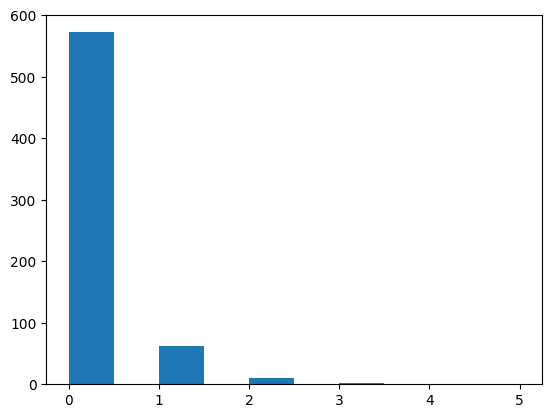

In [33]:
from matplotlib import pyplot as plt

plt.hist([len(v['FP']) for v in ret.values()])

(array([632.,   0.,   0.,   0.,   0.,  12.,   0.,   0.,   0.,   4.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

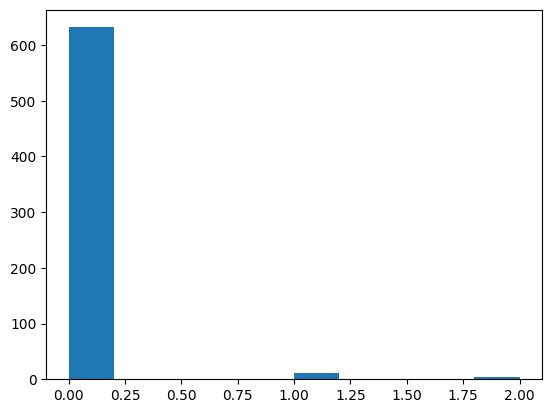

In [34]:
from matplotlib import pyplot as plt

plt.hist([len(v['FN']) for v in ret.values()])

In [15]:
import os
from typing import Tuple

import cv2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
from IPython.display import Image
from IPython.display import display as idisplay
import logging


def viz_label(
    tomo_dir: str,
    ori_spacing: float,
    ori_shape: Tuple[int],
    ref_keypoint: list[list[float]],
    sub_keypoints: list[list[float]] | None = None,
    tag: str = "",
    ref_color: Tuple[int] = (255, 0, 0),
    sub_color: Tuple[int] = (0, 255, 0),
    draw_title: bool = False,
    include_neighbor=False,
):
    """
    Returns: RGB visualization image
    """
    Z, Y, X = [int(e) for e in ori_shape]
    r = round(1000 / ori_spacing)
    z, y, x = [round(e) for e in ref_keypoint[:3]]
    if len(ref_keypoint) == 3:
        conf = None
    else:
        conf = ref_keypoint[3]

    if z == -1:
        has_kpt = False
        assert z == y == x == -1
        z = Z // 2
    else:
        has_kpt = True
    if z > Z:
        raise ValueError(f'Invalid value of z={z} Z={Z}')
    elif z == Z:
        logger.warning('Visualization with z==Z==%d', z)
        z -= 1

    nearby_stride = max(1, round(250. / ori_spacing))
    z_before = max(z-nearby_stride, 0)
    z_after = min(z+nearby_stride, Z-1)

    vizs = []
    for slice_at_z in [z_before, z, z_after]:
        img_viz = cv2.imread(os.path.join(tomo_dir, f"slice_{slice_at_z:04d}.jpg"), cv2.IMREAD_COLOR)
        Y, X = img_viz.shape[:2]
        if draw_title:
            cv2.putText(
                heatmap_viz,
                f"{Z}x{Y}x{X}",
                (0, 120),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 255, 255),
                thickness=2,
            )
    
        if sub_keypoints is not None:
            for sub_kpt in sub_keypoints:
                z2, y2, x2 = [round(e) for e in sub_kpt[:3]]
                r2 = round(max(0.0, (r**2 - (z2 - slice_at_z) ** 2)) ** 0.5)
                assert r2 >= 0
                if r2 > 0:
                    cv2.circle(img_viz, (x2, y2), radius=r2, color=sub_color, thickness=3)
    
        if has_kpt:
            r2 = round(max(0.0, (r**2 - (z - slice_at_z) ** 2)) ** 0.5)
            cv2.circle(img_viz, (x, y), radius=r2, color=ref_color, thickness=3)
            cv2.putText(
                img_viz,
                f'{conf:.2f} {(z,y,x)} {slice_at_z}' if conf is not None else f'{(z,y,x)} {slice_at_z}',
                (0, 40),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (255, 255, 255),
                thickness=2,
            )
        vizs.append(img_viz)

    final_viz = np.concatenate(vizs, axis=1)  # (H, 3*W, C)
    return final_viz


In [ ]:
# !rm -rf /home/dangnh36/datasets/.comp/byu/processed/pseudo_label/round2/

tomo_00e463


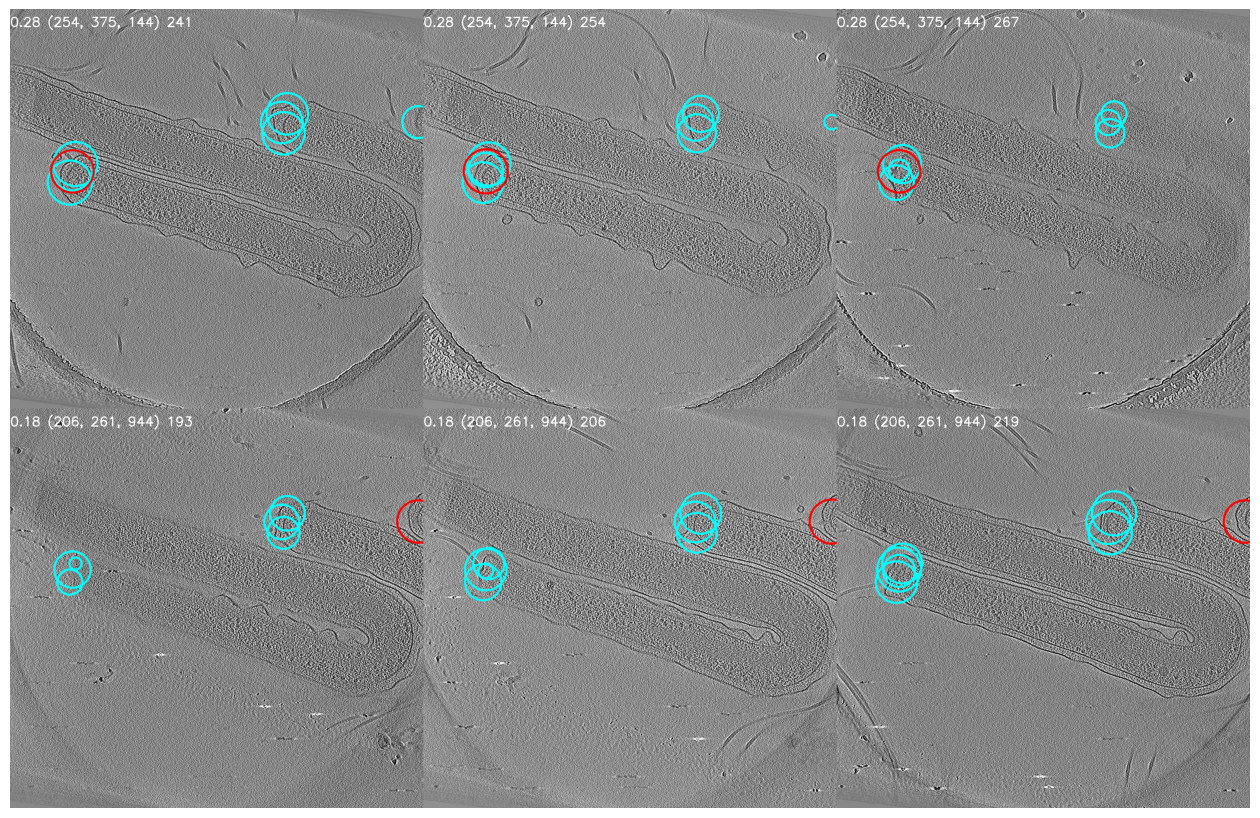

tomo_0333fa


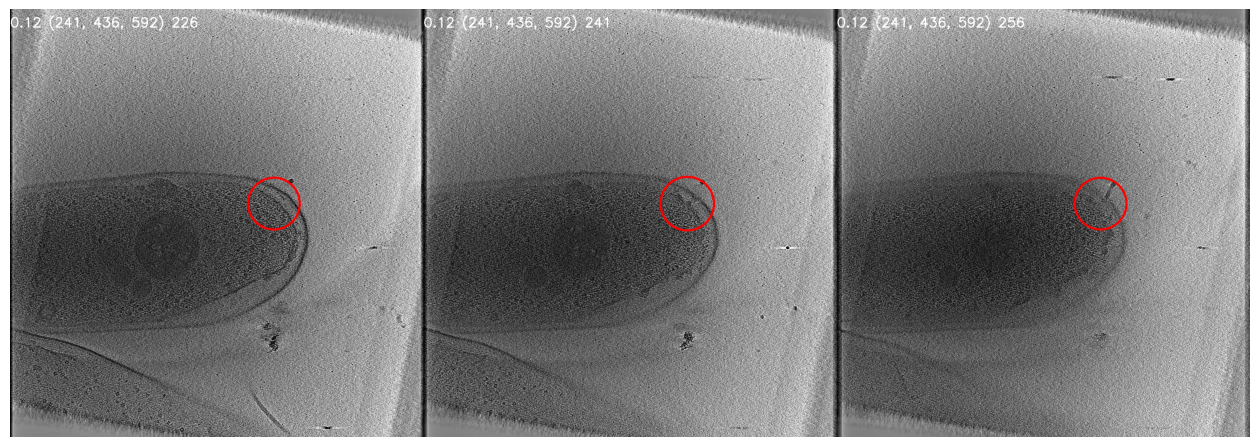

tomo_049310


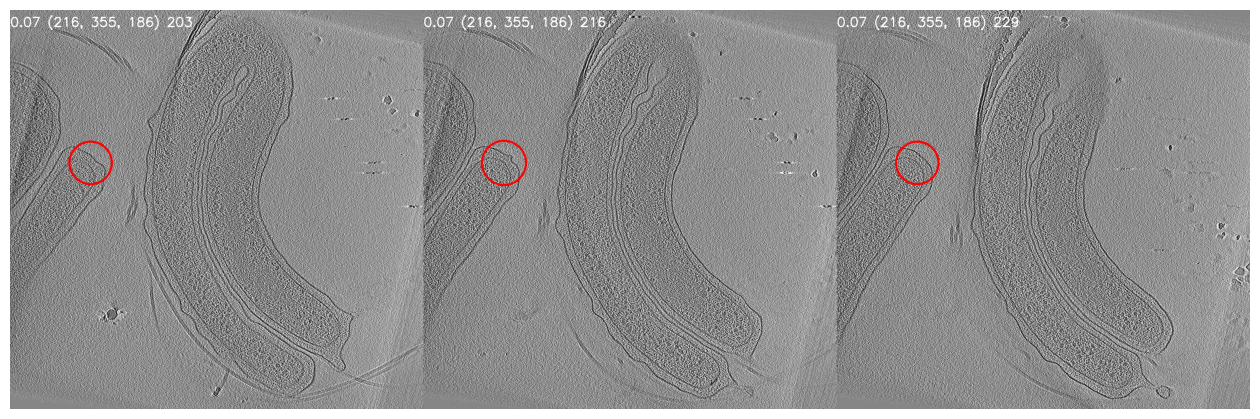

In [17]:
SAVE_DIR = '/home/dangnh36/datasets/.comp/byu/processed/pseudo_label/round2/FP'
try:
    shutil.rmtree(SAVE_DIR)
except:
    pass
os.makedirs(SAVE_DIR, exist_ok=False)

########### FP ###########
count = 0
for tomo_id, v in ret.items():
    tomo_dir = f'/home/dangnh36/datasets/.comp/byu/raw/train/{tomo_id}'
    ref_keypoints = [[*zyx, conf] for zyx, conf in zip(v['FP'], v['FP_conf'])]
    if len(ref_keypoints) == 0:
        continue
    sub_keypoints = v['TP'] + v['FN'] + v['FP']
    vizs = []
    for ref_keypoint in ref_keypoints:
        viz = viz_label(
            tomo_dir,
            ori_spacing = v['voxel_spacing'],
            ori_shape = v['tomo_shape'],
            ref_keypoint = ref_keypoint,
            sub_keypoints = sub_keypoints,
            tag = "FP",
            ref_color = (255, 0, 0),
            sub_color = (0, 255, 255),
            draw_title = False,
            include_neighbor=False,
            )
        vizs.append(viz)
    viz = np.concatenate(vizs, axis = 0)
    
    count += 1
    if count <= 3:
        print(tomo_id)
        plt.figure(figsize=(16, 16))
        plt.imshow(viz)
        plt.axis('off')
        plt.show()
    
    save_path = os.path.join(SAVE_DIR, f"FP-{tomo_id}-{'x'.join([str(int(e)) for e in v['tomo_shape']])}-spacing{v['voxel_spacing']}.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

tomo_00e463


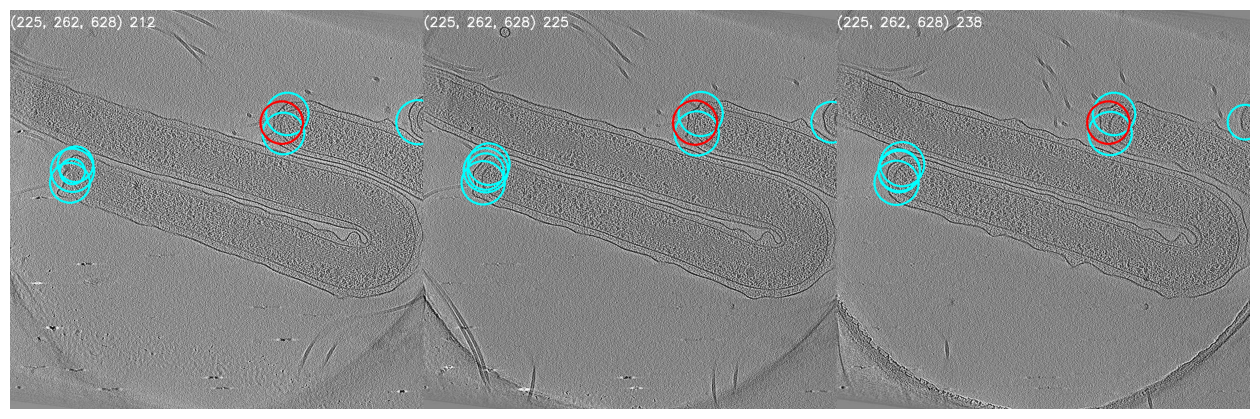

tomo_1b82d1


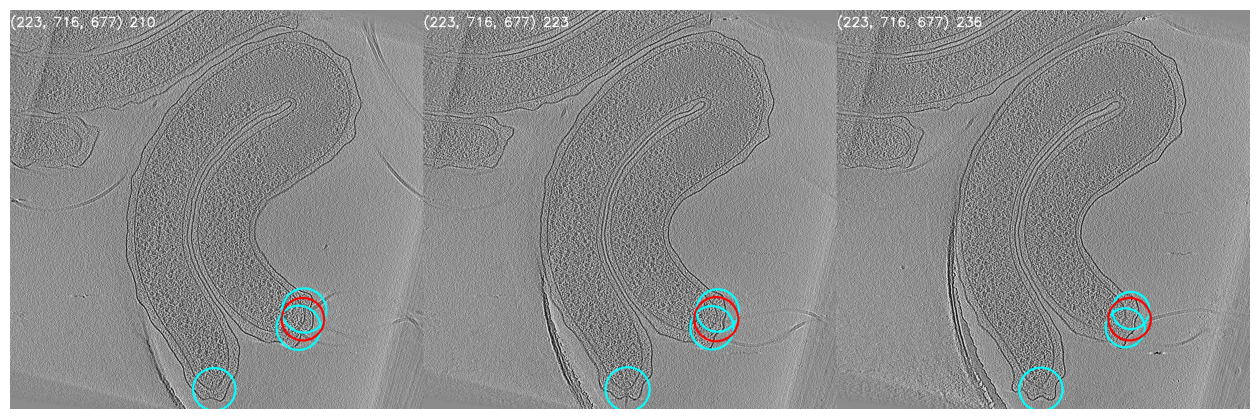

tomo_226cd8


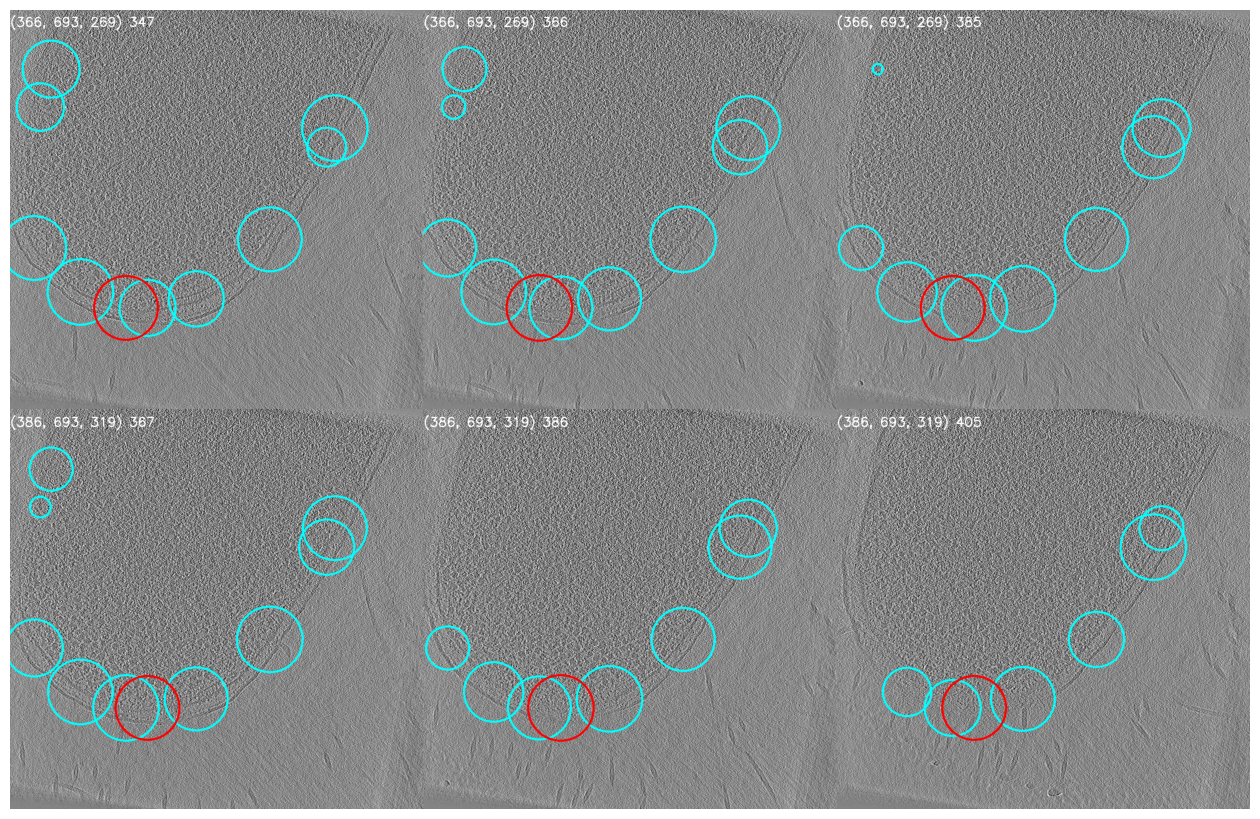

In [19]:
SAVE_DIR = '/home/dangnh36/datasets/.comp/byu/processed/pseudo_label/round2/FN/'

try:
    shutil.rmtree(SAVE_DIR)
except:
    pass
os.makedirs(SAVE_DIR, exist_ok=False)

########### FN ###########
count = 0
for tomo_id, v in ret.items():
    tomo_dir = f'/home/dangnh36/datasets/.comp/byu/raw/train/{tomo_id}'
    ref_keypoints = v['FN']
    if len(ref_keypoints) == 0:
        continue
    sub_keypoints = v['TP'] + v['FN'] + v['FP']
    vizs = []
    for ref_keypoint in ref_keypoints:
        viz = viz_label(
            tomo_dir,
            ori_spacing = v['voxel_spacing'],
            ori_shape = v['tomo_shape'],
            ref_keypoint = ref_keypoint,
            sub_keypoints = sub_keypoints,
            tag = "FN",
            ref_color = (255, 0, 0),
            sub_color = (0, 255, 255),
            draw_title = False,
            include_neighbor=False,
            )
        vizs.append(viz)
    viz = np.concatenate(vizs, axis = 0)

    count += 1
    if count <= 3:
        print(tomo_id)
        plt.figure(figsize=(16, 16))
        plt.imshow(viz)
        plt.axis('off')
        plt.show()
    
    save_path = os.path.join(SAVE_DIR, f"FP-{tomo_id}-{'x'.join([str(int(e)) for e in v['tomo_shape']])}-spacing{v['voxel_spacing']}.jpg")
    cv2.imwrite(save_path, cv2.cvtColor(viz, cv2.COLOR_RGB2BGR))

# Create gt_external.csv

In [3]:
with open('/home/dangnh36/datasets/.comp/byu/processed/pseudo_label/round2/meta.json', 'r') as f:
    meta = json.load(f)
print(len(meta))
print(list(meta.keys())[0])
print(list(meta.values())[0])

648
tomo_003acc
{'TP': [], 'TP_from_gt': [], 'TP_conf': [], 'FN': [], 'FP': [], 'FP_conf': [], 'voxel_spacing': 6.5, 'tomo_shape': [500, 1912, 1847]}


In [4]:
import xml.etree.ElementTree as ET
import polars as pl


def parse_cvat_tag_annotations(xml_file_path):
    """
    Parse a CVAT annotation XML file and return a dictionary mapping filenames to tags.
    
    Args:
        xml_file_path: Path to the CVAT annotation XML file
        
    Returns:
        dict: A dictionary with filenames as keys and lists of tags as values
    """
    # Parse the XML file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    
    # Create a dictionary to store the results
    filename_to_tags = {}
    
    # Iterate through all image elements
    for image in root.findall('.//image'):
        # Get the filename from the 'name' attribute
        filename = image.get('name')
        
        # Initialize an empty list for this filename
        tags = []
        
        # Find all tag elements for this image
        for tag in image.findall('./tag'):
            # Get the label attribute
            label = tag.get('label')
            if label:
                tags.append(label)
        
        # Add the filename and its tags to the dictionary
        filename_to_tags[filename] = tags
    
    return filename_to_tags

In [5]:
fp_anno = parse_cvat_tag_annotations("/home/dangnh36/datasets/.comp/byu/processed/pseudo_label/round2/cvat.xml")
print(fp_anno)

{'FP/FP-tomo_00e463-500x924x956-spacing19.7.jpg': ['0', '1'], 'FP/FP-tomo_0333fa-300x960x928-spacing16.8.jpg': ['0'], 'FP/FP-tomo_049310-500x924x956-spacing19.7.jpg': [], 'FP/FP-tomo_05f919-300x959x928-spacing15.6.jpg': ['0'], 'FP/FP-tomo_08a6d6-800x928x960-spacing13.1.jpg': [], 'FP/FP-tomo_098751-500x924x956-spacing16.1.jpg': ['0', '1'], 'FP/FP-tomo_0d4c9e-300x960x928-spacing15.6.jpg': [], 'FP/FP-tomo_0de3ee-500x928x960-spacing13.1.jpg': ['0'], 'FP/FP-tomo_0eb994-300x959x928-spacing15.6.jpg': ['0'], 'FP/FP-tomo_0f9df0-300x960x928-spacing15.6.jpg': ['0'], 'FP/FP-tomo_10c564-300x960x928-spacing13.1.jpg': ['0'], 'FP/FP-tomo_136c8d-500x924x956-spacing19.7.jpg': [], 'FP/FP-tomo_1cc887-300x928x928-spacing15.6.jpg': ['0'], 'FP/FP-tomo_1da097-500x928x960-spacing13.1.jpg': ['0'], 'FP/FP-tomo_23c8a4-300x960x928-spacing16.8.jpg': ['0'], 'FP/FP-tomo_285454-300x956x924-spacing16.1.jpg': ['1'], 'FP/FP-tomo_28f9c1-500x924x956-spacing16.1.jpg': ['0'], 'FP/FP-tomo_2b996c-300x960x928-spacing16.8.jpg': 

In [6]:
len(fp_anno)

76

In [7]:
fp_anno = {'-'.join(os.path.basename(k)[3:].split('-')[:-2]): [int(e) for e in v] for k, v in fp_anno.items()}
fp_anno

{'tomo_00e463': [0, 1],
 'tomo_0333fa': [0],
 'tomo_049310': [],
 'tomo_05f919': [0],
 'tomo_08a6d6': [],
 'tomo_098751': [0, 1],
 'tomo_0d4c9e': [],
 'tomo_0de3ee': [0],
 'tomo_0eb994': [0],
 'tomo_0f9df0': [0],
 'tomo_10c564': [0],
 'tomo_136c8d': [],
 'tomo_1cc887': [0],
 'tomo_1da097': [0],
 'tomo_23c8a4': [0],
 'tomo_285454': [1],
 'tomo_28f9c1': [0],
 'tomo_2b996c': [0],
 'tomo_2cace2': [],
 'tomo_3183d2': [0],
 'tomo_319f79': [],
 'tomo_37dd38': [0],
 'tomo_39b15b': [],
 'tomo_493bea': [],
 'tomo_4e41c2': [],
 'tomo_507b7a': [0],
 'tomo_5764d6': [0],
 'tomo_5e2a91': [0],
 'tomo_62eea8': [0],
 'tomo_634b06': [0, 1, 2],
 'tomo_656915': [0],
 'tomo_6c5a26': [0],
 'tomo_6cf2df': [],
 'tomo_754447': [0],
 'tomo_78b03d': [],
 'tomo_8d2d48': [],
 'tomo_8ee8fd': [0],
 'tomo_8f4d60': [],
 'tomo_91c84c': [0],
 'tomo_95c0eb': [],
 'tomo_9722d1': [],
 'tomo_997240': [0],
 'tomo_9cd09e': [0],
 'tomo_9f1828': [],
 'tomo_a4c52f': [],
 'tomo_a67e9f': [0],
 'tomo_a8073d': [],
 'tomo_a9d067': [],

In [8]:
for k in fp_anno:
    assert k in meta

In [9]:
all_rows = []
for tomo_id, tomo_meta in meta.items():
    Z, Y, X = tomo_meta['tomo_shape']
    # recalculate all keypoints here
    motor_zyxs = tomo_meta['TP_from_gt'] + tomo_meta['FN'] + [tomo_meta['FP'][idx] for idx in fp_anno.get(tomo_id, [])]
    row = {
        'tomo_id': tomo_id,
        'Z': Z,
        'Y': Y,
        'X': X,
        'voxel_spacing': tomo_meta['voxel_spacing'],
        'num_motors': len(motor_zyxs),
        'motor_z': motor_zyxs[0][0] if len(motor_zyxs) > 0 else -1,
        'motor_y': motor_zyxs[0][1] if len(motor_zyxs) > 0 else -1,
        'motor_x': motor_zyxs[0][2] if len(motor_zyxs) > 0 else -1,
        'motor_zyx': motor_zyxs,
    }
    all_rows.append(row)

print(len(all_rows))
train_df = pl.DataFrame(all_rows)
train_df

648


shape: (648, 10)
┌─────────────┬─────┬──────┬──────┬───┬─────────┬─────────┬─────────┬─────────────────────────┐
│ tomo_id     ┆ Z   ┆ Y    ┆ X    ┆ … ┆ motor_z ┆ motor_y ┆ motor_x ┆ motor_zyx               │
│ ---         ┆ --- ┆ ---  ┆ ---  ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---                     │
│ str         ┆ i64 ┆ i64  ┆ i64  ┆   ┆ f64     ┆ f64     ┆ f64     ┆ list[list[f64]]         │
╞═════════════╪═════╪══════╪══════╪═══╪═════════╪═════════╪═════════╪═════════════════════════╡
│ tomo_003acc ┆ 500 ┆ 1912 ┆ 1847 ┆ … ┆ -1.0    ┆ -1.0    ┆ -1.0    ┆ []                      │
│ tomo_00e047 ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 169.0   ┆ 546.0   ┆ 603.0   ┆ [[169.0, 546.0, 603.0]] │
│ tomo_00e463 ┆ 500 ┆ 924  ┆ 956  ┆ … ┆ 235.0   ┆ 403.0   ┆ 137.0   ┆ [[235.0, 403.0, 137.0], │
│             ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ [243.0…                 │
│ tomo_01a877 ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ 147.0   ┆ 638.0   ┆ 286.0   ┆ [[147.0, 638.0, 286.0]] │
│ tomo_02862f ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 101.0   ┆ 351.0   ┆ 120.0   ┆ [[101.0, 351.0, 120.0]] │
│ …           ┆ …   ┆ …    ┆ …    ┆ … ┆ …       ┆ …       ┆ …       ┆ …                       │
│ tomo_fe050c ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 138.0   ┆ 134.0   ┆ 542.0   ┆ [[138.0, 134.0, 542.0], │
│             ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ [143.1…                 │
│ tomo_fe85f6 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 463.5   ┆ 903.5   ┆ 747.0   ┆ [[463.5, 903.5, 747.0]] │
│ tomo_fea6e8 ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ -1.0    ┆ -1.0    ┆ -1.0    ┆ []                      │
│ tomo_ff505c ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 111.0   ┆ 816.0   ┆ 678.0   ┆ [[111.0, 816.0, 678.0]] │
│ tomo_ff7c20 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 307.25  ┆ 493.0   ┆ 63.0    ┆ [[307.25, 493.0, 63.0]] │
└─────────────┴─────┴──────┴──────┴───┴─────────┴─────────┴─────────┴─────────────────────────┘

In [10]:
meta['tomo_fe050c'], train_df.filter(pl.col('tomo_id') == 'tomo_fe050c')['motor_zyx'][0].to_list()

({'TP': [[136.875, 132.875, 539.0], [141.0, 95.9375, 403.5]],
  'TP_from_gt': [[138.0, 134.0, 542.0], [143.125, 93.875, 405.75]],
  'TP_conf': [0.64892578125, 0.677734375],
  'FN': [],
  'FP': [],
  'FP_conf': [],
  'voxel_spacing': 15.6,
  'tomo_shape': [300, 959, 928]},
 [[138.0, 134.0, 542.0], [143.125, 93.875, 405.75]])

In [12]:
train_df = train_df.with_columns(
    pl.col('motor_zyx').map_elements(lambda x: str([e for e in x.to_list() if e[0] >= 0]), return_dtype = pl.String)
)
train_df

shape: (648, 10)
┌─────────────┬─────┬──────┬──────┬───┬─────────┬─────────┬─────────┬─────────────────────────┐
│ tomo_id     ┆ Z   ┆ Y    ┆ X    ┆ … ┆ motor_z ┆ motor_y ┆ motor_x ┆ motor_zyx               │
│ ---         ┆ --- ┆ ---  ┆ ---  ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---                     │
│ str         ┆ i64 ┆ i64  ┆ i64  ┆   ┆ f64     ┆ f64     ┆ f64     ┆ str                     │
╞═════════════╪═════╪══════╪══════╪═══╪═════════╪═════════╪═════════╪═════════════════════════╡
│ tomo_003acc ┆ 500 ┆ 1912 ┆ 1847 ┆ … ┆ -1.0    ┆ -1.0    ┆ -1.0    ┆ []                      │
│ tomo_00e047 ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 169.0   ┆ 546.0   ┆ 603.0   ┆ [[169.0, 546.0, 603.0]] │
│ tomo_00e463 ┆ 500 ┆ 924  ┆ 956  ┆ … ┆ 235.0   ┆ 403.0   ┆ 137.0   ┆ [[235.0, 403.0, 137.0], │
│             ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ [243.0…                 │
│ tomo_01a877 ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ 147.0   ┆ 638.0   ┆ 286.0   ┆ [[147.0, 638.0, 286.0]] │
│ tomo_02862f ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 101.0   ┆ 351.0   ┆ 120.0   ┆ [[101.0, 351.0, 120.0]] │
│ …           ┆ …   ┆ …    ┆ …    ┆ … ┆ …       ┆ …       ┆ …       ┆ …                       │
│ tomo_fe050c ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 138.0   ┆ 134.0   ┆ 542.0   ┆ [[138.0, 134.0, 542.0], │
│             ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ [143.1…                 │
│ tomo_fe85f6 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 463.5   ┆ 903.5   ┆ 747.0   ┆ [[463.5, 903.5, 747.0]] │
│ tomo_fea6e8 ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ -1.0    ┆ -1.0    ┆ -1.0    ┆ []                      │
│ tomo_ff505c ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 111.0   ┆ 816.0   ┆ 678.0   ┆ [[111.0, 816.0, 678.0]] │
│ tomo_ff7c20 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 307.25  ┆ 493.0   ┆ 63.0    ┆ [[307.25, 493.0, 63.0]] │
└─────────────┴─────┴──────┴──────┴───┴─────────┴─────────┴─────────┴─────────────────────────┘

In [13]:
train_df['voxel_spacing'].describe()

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 648.0     │
│ null_count ┆ 0.0       │
│ mean       ┆ 15.066204 │
│ std        ┆ 2.152598  │
│ min        ┆ 6.5       │
│ 25%        ┆ 13.1      │
│ 50%        ┆ 15.6      │
│ 75%        ┆ 16.1      │
│ max        ┆ 19.7      │
└────────────┴───────────┘

In [ ]:
display(ext_df['num_motors'].describe())
plt.hist(ext_df['num_motors'])

In [14]:
train_df.write_csv('/home/dangnh36/datasets/.comp/byu/processed/gt_v3.csv')

In [15]:
train_df.columns

['tomo_id',
 'Z',
 'Y',
 'X',
 'voxel_spacing',
 'num_motors',
 'motor_z',
 'motor_y',
 'motor_x',
 'motor_zyx']

In [16]:
ext_df = pl.scan_csv('/home/dangnh36/datasets/.comp/byu/processed/external_gt.csv').select(pl.col('tomo_id', 'Z', 'Y', 'X', 'voxel_spacing', 'num_motors', 'motor_z', 'motor_y', 'motor_x', 'motor_zyx')).collect()
ext_df

shape: (1_287, 10)
┌──────────────────┬─────┬─────┬─────┬───┬─────────┬─────────┬─────────┬───────────────────────────┐
│ tomo_id          ┆ Z   ┆ Y   ┆ X   ┆ … ┆ motor_z ┆ motor_y ┆ motor_x ┆ motor_zyx                 │
│ ---              ┆ --- ┆ --- ┆ --- ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---                       │
│ str              ┆ i64 ┆ i64 ┆ i64 ┆   ┆ f64     ┆ f64     ┆ f64     ┆ str                       │
╞══════════════════╪═════╪═════╪═════╪═══╪═════════╪═════════╪═════════╪═══════════════════════════╡
│ aba2013-04-06-10 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 281.5   ┆ 229.5   ┆ 445.5   ┆ [[281.5, 229.5, 445.5]]   │
│ aba2013-04-06-12 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 281.5   ┆ 221.5   ┆ 289.5   ┆ [[281.5, 221.5, 289.5]]   │
│ aba2013-04-06-13 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 265.5   ┆ 597.5   ┆ 281.5   ┆ [[265.5, 597.5, 281.5]]   │
│ aba2013-04-06-14 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 249.5   ┆ 169.5   ┆ 301.5   ┆ [[249.5, 169.5, 301.5]]   │
│ aba2013-04-06-15 ┆ 541 ┆ 625 ┆ 647 ┆ … ┆ 297.5   ┆ 105.5   ┆ 497.5   ┆ [[297.5, 105.5, 497.5],   │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [273.5…                   │
│ …                ┆ …   ┆ …   ┆ …   ┆ … ┆ …       ┆ …       ┆ …       ┆ …                         │
│ ycw2013-11-24-19 ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 439.0   ┆ 173.0   ┆ 419.5   ┆ [[439.0, 173.0, 419.5],   │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [406.5…                   │
│ ycw2013-11-24-2  ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 429.25  ┆ 799.0   ┆ 834.5   ┆ [[429.25, 799.0, 834.5]]  │
│ ycw2013-11-24-24 ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 348.25  ┆ 332.0   ┆ 260.5   ┆ [[348.25, 332.0, 260.5],  │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ [328.…                    │
│ ycw2013-11-24-5  ┆ 800 ┆ 928 ┆ 960 ┆ … ┆ 396.75  ┆ 150.375 ┆ 620.5   ┆ [[396.75, 150.375,        │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ 620.5], [42…              │
│ ycw2017-11-30-30 ┆ 600 ┆ 928 ┆ 960 ┆ … ┆ 354.25  ┆ 227.375 ┆ 632.0   ┆ [[354.25, 227.375,        │
│                  ┆     ┆     ┆     ┆   ┆         ┆         ┆         ┆ 632.0], [35…              │
└──────────────────┴─────┴─────┴─────┴───┴─────────┴─────────┴─────────┴───────────────────────────┘

In [17]:
concat_df = pl.concat([train_df, ext_df])
concat_df

shape: (1_935, 10)
┌──────────────────┬─────┬──────┬──────┬───┬─────────┬─────────┬─────────┬─────────────────────────┐
│ tomo_id          ┆ Z   ┆ Y    ┆ X    ┆ … ┆ motor_z ┆ motor_y ┆ motor_x ┆ motor_zyx               │
│ ---              ┆ --- ┆ ---  ┆ ---  ┆   ┆ ---     ┆ ---     ┆ ---     ┆ ---                     │
│ str              ┆ i64 ┆ i64  ┆ i64  ┆   ┆ f64     ┆ f64     ┆ f64     ┆ str                     │
╞══════════════════╪═════╪══════╪══════╪═══╪═════════╪═════════╪═════════╪═════════════════════════╡
│ tomo_003acc      ┆ 500 ┆ 1912 ┆ 1847 ┆ … ┆ -1.0    ┆ -1.0    ┆ -1.0    ┆ []                      │
│ tomo_00e047      ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 169.0   ┆ 546.0   ┆ 603.0   ┆ [[169.0, 546.0, 603.0]] │
│ tomo_00e463      ┆ 500 ┆ 924  ┆ 956  ┆ … ┆ 235.0   ┆ 403.0   ┆ 137.0   ┆ [[235.0, 403.0, 137.0], │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ [243.0…                 │
│ tomo_01a877      ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ 147.0   ┆ 638.0   ┆ 286.0   ┆ [[147.0, 638.0, 286.0]] │
│ tomo_02862f      ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 101.0   ┆ 351.0   ┆ 120.0   ┆ [[101.0, 351.0, 120.0]] │
│ …                ┆ …   ┆ …    ┆ …    ┆ … ┆ …       ┆ …       ┆ …       ┆ …                       │
│ ycw2013-11-24-19 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 439.0   ┆ 173.0   ┆ 419.5   ┆ [[439.0, 173.0, 419.5], │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ [406.5…                 │
│ ycw2013-11-24-2  ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 429.25  ┆ 799.0   ┆ 834.5   ┆ [[429.25, 799.0,        │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ 834.5]]                 │
│ ycw2013-11-24-24 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 348.25  ┆ 332.0   ┆ 260.5   ┆ [[348.25, 332.0,        │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ 260.5], [328.…          │
│ ycw2013-11-24-5  ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 396.75  ┆ 150.375 ┆ 620.5   ┆ [[396.75, 150.375,      │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ 620.5], [42…            │
│ ycw2017-11-30-30 ┆ 600 ┆ 928  ┆ 960  ┆ … ┆ 354.25  ┆ 227.375 ┆ 632.0   ┆ [[354.25, 227.375,      │
│                  ┆     ┆      ┆      ┆   ┆         ┆         ┆         ┆ 632.0], [35…            │
└──────────────────┴─────┴──────┴──────┴───┴─────────┴─────────┴─────────┴─────────────────────────┘

In [18]:
concat_df.write_csv('/home/dangnh36/datasets/.comp/byu/processed/all_gt_v3.csv')

In [20]:
old_train_df = pl.scan_csv('/home/dangnh36/datasets/.comp/byu/processed/gt_v2.csv').collect()
old_train_df

shape: (648, 20)
┌─────────────┬─────┬──────┬──────┬───┬──────────┬──────────┬───────────────────┬──────────────────┐
│ tomo_id     ┆ Z   ┆ Y    ┆ X    ┆ … ┆ motor_yA ┆ motor_xA ┆ motor_zyx         ┆ motor_zyxA       │
│ ---         ┆ --- ┆ ---  ┆ ---  ┆   ┆ ---      ┆ ---      ┆ ---               ┆ ---              │
│ str         ┆ i64 ┆ i64  ┆ i64  ┆   ┆ f64      ┆ f64      ┆ str               ┆ str              │
╞═════════════╪═════╪══════╪══════╪═══╪══════════╪══════════╪═══════════════════╪══════════════════╡
│ tomo_003acc ┆ 500 ┆ 1912 ┆ 1847 ┆ … ┆ -6.5     ┆ -6.5     ┆ []                ┆ []               │
│ tomo_00e047 ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 8517.6   ┆ 9406.8   ┆ [[169.0, 546.0,   ┆ [[2636.4,        │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 603.0]]           ┆ 8517.6, 9406.8]] │
│ tomo_00e463 ┆ 500 ┆ 924  ┆ 956  ┆ … ┆ 7939.1   ┆ 2698.9   ┆ [[235.0, 403.0,   ┆ [[4629.5, 7939.0 │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 137.0], [243.0…   ┆ 99999999999, 2…  │
│ tomo_01a877 ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ 8357.8   ┆ 3746.6   ┆ [[147.0, 638.0,   ┆ [[1925.7,        │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 286.0]]           ┆ 8357.8, 3746.6]] │
│ tomo_02862f ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 5475.6   ┆ 1872.0   ┆ [[101.0, 351.0,   ┆ [[1575.6, 5475.5 │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 120.0]]           ┆ 99999999999, 1…  │
│ …           ┆ …   ┆ …    ┆ …    ┆ … ┆ …        ┆ …        ┆ …                 ┆ …                │
│ tomo_fe050c ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 2090.4   ┆ 8455.2   ┆ [[138.0, 134.0,   ┆ [[2152.799999999 │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 542.0], [143.1…   ┆ 9997, 2090.4, …  │
│ tomo_fe85f6 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 11835.85 ┆ 9785.7   ┆ [[463.5, 903.5,   ┆ [[6071.849999999 │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 747.0]]           ┆ 999, 11835.85,…  │
│ tomo_fea6e8 ┆ 300 ┆ 960  ┆ 928  ┆ … ┆ -16.8    ┆ -16.8    ┆ []                ┆ []               │
│ tomo_ff505c ┆ 300 ┆ 959  ┆ 928  ┆ … ┆ 12729.6  ┆ 10576.8  ┆ [[111.0, 816.0,   ┆ [[1731.6,        │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 678.0]]           ┆ 12729.6,         │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆                   ┆ 10576.8]]        │
│ tomo_ff7c20 ┆ 800 ┆ 928  ┆ 960  ┆ … ┆ 6458.3   ┆ 825.3    ┆ [[307.25, 493.0,  ┆ [[4024.975,      │
│             ┆     ┆      ┆      ┆   ┆          ┆          ┆ 63.0]]            ┆ 6458.3, 825.3]]  │
└─────────────┴─────┴──────┴──────┴───┴──────────┴──────────┴───────────────────┴──────────────────┘

In [21]:
for row in train_df.iter_rows(named = True):
    tomo_id = row['tomo_id']
    num_motors = len(eval(row['motor_zyx']))
    assert num_motors == row['num_motors']
    len2 = old_train_df.filter(pl.col('tomo_id') == tomo_id)['num_motors'][0]
    assert num_motors >= len2
    if num_motors > len2:
        print(tomo_id, len2, '-->', num_motors)

tomo_00e463 6 --> 8
tomo_0333fa 0 --> 1
tomo_05f919 1 --> 2
tomo_098751 0 --> 2
tomo_0de3ee 2 --> 3
tomo_0eb994 1 --> 2
tomo_0f9df0 1 --> 2
tomo_10c564 1 --> 2
tomo_1cc887 1 --> 2
tomo_1da097 2 --> 3
tomo_23c8a4 2 --> 3
tomo_285454 0 --> 1
tomo_28f9c1 1 --> 2
tomo_2b996c 0 --> 1
tomo_3183d2 1 --> 2
tomo_37dd38 3 --> 4
tomo_507b7a 2 --> 3
tomo_5764d6 1 --> 2
tomo_5e2a91 1 --> 2
tomo_62eea8 1 --> 2
tomo_634b06 4 --> 7
tomo_656915 1 --> 2
tomo_6c5a26 1 --> 2
tomo_754447 2 --> 3
tomo_8ee8fd 0 --> 1
tomo_91c84c 1 --> 2
tomo_997240 2 --> 3
tomo_9cd09e 1 --> 2
tomo_a67e9f 1 --> 2
tomo_ae347a 2 --> 3
tomo_aec312 2 --> 3
tomo_b0e5c6 1 --> 2
tomo_b11ddc 0 --> 1
tomo_b33d4e 2 --> 3
tomo_b4a1f0 4 --> 5
tomo_b7d014 2 --> 4
tomo_bb5ac1 0 --> 1
tomo_c649f8 1 --> 2
tomo_c84b8e 1 --> 2
tomo_c9d07c 0 --> 1
tomo_cad74b 3 --> 4
tomo_dfc627 1 --> 2
tomo_e22370 3 --> 7
tomo_e6f7f7 1 --> 2
tomo_ec607b 2 --> 3
tomo_ef1a1a 0 --> 1
